In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
sess = tf.InteractiveSession()

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist_data = input_data.read_data_sets('MNIST_data', one_hot=False)
mnist_data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x106b504a8>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x106b504e0>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x106b50390>)

In [19]:
WIDTH, HEIGHT = (28, 28)

unique_labels = np.unique(mnist_data.train.labels)
print('Train has {} dimensions with {} unique classe: {}'.format(mnist_data.train.images.shape, len(unique_labels), unique_labels))

Train has (55000, 784) dimensions with 10 unique classe: [0 1 2 3 4 5 6 7 8 9]


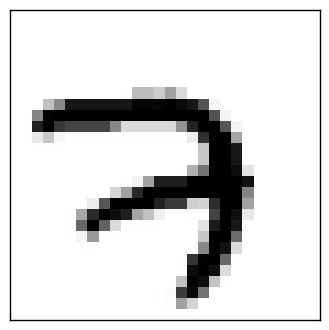

In [6]:
def show_image(pixels):
    plt.imshow(pixels.reshape((WIDTH, HEIGHT)), cmap='Greys', interpolation='None');
    plt.xticks([]); plt.yticks([]);

show_image(mnist_data.train.images[0])

## Tensorflow solution

 * Re-user softmax classification from https://github.com/pilipolio/schibsted-study/blob/master/notebooks/201611_multiclass_classification.ipynb
     * Adapt number of classes and train_X dimension
     * Define `train_X` and `train_Y` from mnist_data.train.images/labels
 * Calculate the accuracy (ratio of correctly classified labels)
 * Think about a way to visualise the fitted weights
 * Improve the accuracy of the naive model by adding non-linear layers (see https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html)

In [22]:
n_samples, D = mnist_data.train.images.shape
C = unique_labels.shape[0]

n_samples, D, C

(55000, 784, 10)

In [23]:
train_X = mnist_data.train.images
train_Y = mnist_data.train.labels

train_X[:10,:]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [28]:
X = tf.placeholder("float", shape = [None, D])
Y = tf.placeholder("int32", shape = [None])

W = tf.Variable(tf.zeros_initializer(shape=(D, C)))
sess.run(W.initializer)

scores = tf.matmul(X, W)

probabilities = tf.nn.softmax(scores)

softmax_sample_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=scores,
    labels=Y)

softmax_loss = tf.reduce_mean(softmax_sample_losses)

sess.run(softmax_sample_losses, feed_dict={X: train_X[:5, :], Y: train_Y[:5]})

array([ 2.30258512,  2.30258512,  2.30258512,  2.30258512,  2.30258512], dtype=float32)

In [30]:
# Parameters
learning_rate = 0.01
n_epochs = 100
display_step = 10

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(softmax_loss)
init = tf.initialize_all_variables()

# storing weights for each epochs for later visualisation
fitted_ws = np.zeros((n_epochs, D*C))

for epoch in range(n_epochs):
    # feeding the full training set for every epoch
    _, fitted_w, cost_value, predicted_probs = sess.run(
        [optimizer, W, softmax_loss, probabilities],
        feed_dict={X: train_X, Y: train_Y})
    
    fitted_ws[epoch, :] = fitted_w.ravel()

    if (epoch) % display_step == 0:
        print("Epoch: {:4d}, cost={:.4f} W={}".format(epoch, cost_value, fitted_w.ravel()))
        
predicted_classes = sess.run(tf.arg_max(probabilities, dimension=1), feed_dict={X: train_X})

Epoch:    0, cost=1.8708 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   10, cost=1.8000 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   20, cost=1.7343 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   30, cost=1.6733 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   40, cost=1.6167 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   50, cost=1.5642 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   60, cost=1.5154 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   70, cost=1.4700 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   80, cost=1.4277 W=[ 0.  0.  0. ...,  0.  0.  0.]
Epoch:   90, cost=1.3883 W=[ 0.  0.  0. ...,  0.  0.  0.]


In [32]:
np.sum(predicted_classes == train_Y) / train_Y.shape[0]

0.79401818181818185

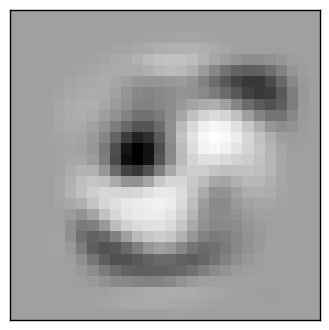

In [38]:
show_image(fitted_w[:, 5])

## Keras for high-level layers definition 

In [11]:
# from https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
from keras import backend as K
K.set_session(sess)

In [12]:
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential

n_variable_samples = None
n_channels  = 1
input_images = tf.placeholder(tf.float32, shape=(n_variable_samples, HEIGHT*WIDTH), name='images')
input_labels = tf.placeholder(tf.int64, shape=(n_variable_samples), name='labels')

model = Sequential()

input_layer = Convolution2D(
    nb_filter=9, nb_row=3, nb_col=3, border_mode='valid', activation='relu', dim_ordering='tf')
input_layer.set_input(
    tf.reshape(input_images, shape=(-1, WIDTH, HEIGHT, n_channels)), 
    shape=(None, WIDTH, HEIGHT, n_channels))

model.add(input_layer)
model.add(Convolution2D(
    nb_filter=9, nb_row=3, nb_col=3, activation='relu', dim_ordering='tf'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(output_dim=512, activation='relu', name='relu2'))
model.add(Dense(output_dim=C, bias=True, activation='linear', name='logits'))
logits = model.output

probabilities = tf.nn.softmax(logits, name='softmax')
probabilities

<tf.Tensor 'softmax:0' shape=(?, 10) dtype=float32>

In [16]:
from itertools import chain

for var in chain.from_iterable(m.weights for m in model.layers):
    sess.run(var.initializer)

In [17]:
softmax_sample_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits,
    labels=input_labels)

softmax_sample_losses
softmax_loss = tf.reduce_mean(softmax_sample_losses)
#train_step = tf.train.GradientDescentOptimizer(0.1).minimize(softmax_loss)
train_step = tf.train.AdamOptimizer(1e-4).minimize(softmax_loss)

In [18]:
for i in range(1000):
    batch = mnist_data.train.next_batch(50)
    train_step.run(feed_dict={input_images: batch[0],
                              input_labels: batch[1]})

    if i % 100 == 0:
        print(i)
        print('batch average loss', sess.run(
            softmax_loss, 
            feed_dict={
                input_images: mnist_data.train.images, 
                input_labels: mnist_data.train.labels}))

FailedPreconditionError: Attempting to use uninitialized value beta1_power_1
	 [[Node: beta1_power_1/read = Identity[T=DT_FLOAT, _class=["loc:@convolution2d_1_W"], _device="/job:localhost/replica:0/task:0/cpu:0"](beta1_power_1)]]
Caused by op 'beta1_power_1/read', defined at:
  File "/Users/gui/miniconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/gui/miniconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2d5496194efc>", line 8, in <module>
    train_step = tf.train.AdamOptimizer(1e-4).minimize(softmax_loss)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 198, in minimize
    name=name)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 300, in apply_gradients
    self._create_slots(var_list)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/training/adam.py", line 112, in _create_slots
    trainable=False)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 211, in __init__
    dtype=dtype)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 323, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1106, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2317, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/gui/miniconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1239, in __init__
    self._traceback = _extract_stack()


In [12]:
correct_labels = tf.cast(tf.equal(tf.arg_max(logits, dimension=1), input_labels), 'float')
with sess.as_default():
    print(tf.reduce_mean(correct_labels).eval(
            feed_dict={input_images: mnist_data.test.images,
                                    input_labels: mnist_data.test.labels,
                       K.learning_phase(): 0}
                      ))

0.9593


(3, 3, 1, 9)


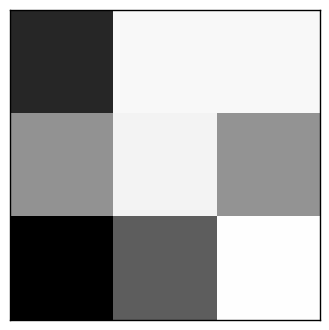

In [13]:
# looking at the conv filter weights 
# http://cs231n.github.io/understanding-cnn/
weight_values = input_layer.weights[0].eval()
print(weight_values.shape)

plt.imshow(weight_values[:, :, 0, 0], cmap='Greys', interpolation='None');
plt.xticks([]); plt.yticks([]); 

(1, 24, 24, 9)


/Users/gui/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


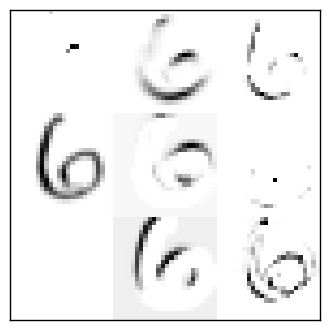

In [16]:
image_activation_by_filters = model.layers[1].output.eval({input_images: mnist_data.test.images[[100],:]})

print(image_activation_by_filters.shape)
_, w, h, n_filters = image_activation_by_filters.shape

n_half_filters = int(np.sqrt(n_filters))
layout_images = np.zeros((w * n_half_filters, h * n_half_filters))
for i in range(n_half_filters):
    for j in range(n_half_filters):
        filtered_image = image_activation_by_filters[0,:,:,i*n_half_filters+j]
        layout_images[(i*w):((i+1)*w),(j*h):((j+1)*h)] = (filtered_image - np.min(filtered_image)) / (np.max(filtered_image) - np.min(filtered_image))
    
plt.imshow(layout_images, cmap='Greys', interpolation='None');
plt.xticks([]); plt.yticks([]);

In [103]:
weight_values[:, 50].reshape((16, 16))

IndexError: index 50 is out of bounds for axis 1 with size 3

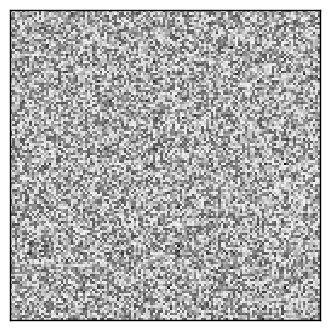

In [206]:
#plt.imshow(weight_values[:, 50].reshape((WIDTH, HEIGHT)), cmap='Greys');
plt.imshow(weight_values, cmap='Greys', interpolation='None');
plt.xticks([]); plt.yticks([]); 

In [63]:
mnist_data.train.images.dot(weight_values).argmax(axis=1)

array([7, 3, 9, ..., 5, 6, 8])

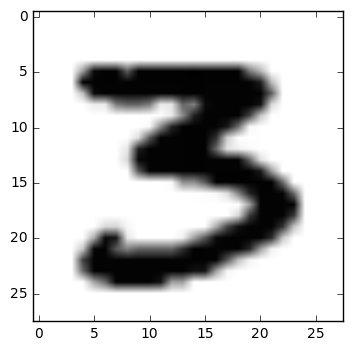

In [162]:
i = i + 1
plt.imshow(mnist_data.train.images[mnist_data.train.labels==3,:][i,:].reshape((WIDTH, HEIGHT)), cmap='Greys');